In [162]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_curve
import tensorflow as tf
import joblib
%matplotlib inline

np.random.seed(3)
tf.random.set_seed(3)

## Data Setting

In [2]:
pre = pd.read_csv('kd_data.csv')

pre_df = pd.DataFrame(pre)

pre_df

,person_id,gender,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,...,Malignant neoplastic disease,Chronic liver disease,chronic obstructive lung disease,cerebrovascular disease,chronic kidney disease,Diabetes mellitus,Ischemic heart disease,hyperlipidemia,Hypertensive disorder,cancer
0,1673221,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1289235,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1690134,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,530465,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,737827,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,1756845,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405,14298,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
406,1646575,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
407,352251,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
pre_df.columns = ['person_id','gender', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_7', 'age_8', 'smoking_status_0.0', 'smoking_status_1.0',
       'smoking_status_2.0', 'smoking_status_3.0', 'bmi_1.0', 'bmi_2.0', 'bmi_3.0',
       'bmi_4.0', 'Malignant_neoplastic_disease', 'Chronic_liver_disease',
       'chronic_obstructive_lung_disease', 'cerebrovascular_disease',
       'chronic_kidney_disease', 'Diabetes_mellitus', 'Ischemic_heart_disease',
       'hyperlipidemia', 'Hypertensive_disorder', 'cancer']

pre_df = pre_df.astype('int64')

In [4]:
# The process of separating layers and features, shuffling them, and creating batches using batch_size
.
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('cancer')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)

    return ds

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train, test = train_test_split(pre_df, test_size=0.3, random_state=3, stratify=pre_df['cancer'])

train_ds= df_to_dataset(train, batch_size=len(train),shuffle=False)
test_ds= df_to_dataset(test, batch_size=len(test),shuffle=False)
all_ds = df_to_dataset(pre_df, batch_size=len(pre_df),shuffle=False)

In [106]:
x_train, x_test, y_train, y_test = train_test_split(pre_df.iloc[:,1:27],pre_df['cancer'], test_size=0.3, stratify=pre_df['cancer'],random_state=3)

In [9]:
print(Counter(pre_df['cancer']))

Counter({0: 320, 1: 89})


In [10]:
x_data = pre_df.iloc[:,1:27]
y_data = pre_df['cancer']

In [58]:
from tensorflow.keras.utils import to_categorical
Y_cate = to_categorical(pre_df['cancer'])
X_data = pre_df.iloc[:,1:27]

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_cate, test_size=0.3, random_state=3)
training, testing = train_test_split(pre_df['cancer'], test_size=0.3, random_state=3)

## Class weight

In [12]:
from sklearn.utils import class_weight

In [13]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(Y_train),y=Y_train)

class_weights

array([0.63839286, 2.30645161])

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

In [15]:
from sklearn import metrics
from tensorflow.keras.layers import Input,Dense,SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1, L2,L1L2
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, RMSprop

In [16]:
from sklearn.metrics import roc_curve, auc

In [19]:
clf_labels = ['SVM','Random Forest']

pred = []

for label in clf_labels:
    model = joblib.load(label+'.pkl') # Loading a saved model.
    model = model.fit(X_train,Y_train)

    real_pred = model.predict(x_data)
    real_pred = [ 1 if x >= 0.5 else 0 for x in real_pred]
    pred.append(real_pred)

In [ ]:
precision_svm, recall_svm,_ = precision_recall_curve(y_test,svm_pred)

In [20]:
[(_, train_label)] = train_ds.take(1)
[(_, test_label)] = test_ds.take(1)
[(_, all_label)] = all_ds.take(1)

In [21]:
DNN = joblib.load('DNN.pkl')

In [22]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
DNN.compile(optimizer=Adam(learning_rate=0.005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [ ]:
history = DNN.fit(train_ds, epochs=100,callbacks=[early_stopping],class_weight = class_weights)

Epoch 1/100


Input dict contained keys ['person_id'] which did not match any model input. They will be ignored by the model.
"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?


1/1 [==============================] - 4s 4s/step - loss: 0.6366 - tp: 45.0000 - fp: 48.0000 - tn: 177.0000 - fn: 16.0000 - accuracy: 0.7762 - precision: 0.4839 - recall: 0.7377 - auc: 0.8482 - prc: 0.5406
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.5932 - tp: 57.0000 - fp: 120.0000 - tn: 105.0000 - fn: 4.0000 - accuracy: 0.5664 - precision: 0.3220 - recall: 0.9344 - auc: 0.8152 - prc: 0.4641
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.6307 - tp: 61.0000 - fp: 149.0000 - tn: 76.0000 - fn: 0.0000e+00 - accuracy: 0.4790 - precision: 0.2905 - recall: 1.0000 - auc: 0.8056 - prc: 0.4115
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.6059 - tp: 60.0000 - fp: 136.0000 - tn: 89.0000 - fn: 1.0000 - accuracy: 0.5210 - precision: 0.3061 - recall: 0.9836 - auc: 0.8394 - prc: 0.5202
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.5563 - tp: 57.0000 - fp: 118.0000 - tn: 107.0000 - fn: 4.0

In [25]:
real_pred = DNN.predict(all_ds)
real_pred = [ 1 if x >= 0.5 else 0 for x in real_pred]
pred.append(real_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['person_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


In [26]:
kd_data = np.array(pred)
print(kd_data.shape)

kd_data = np.transpose(kd_data)
print(kd_data.shape)

(3, 409)
(409, 3)


## KD Ensemble Model

In [27]:
em_data = pd.DataFrame(kd_data, columns=['SVM','RF','DL'])
em_data.head()

,SVM,RF,DL
0,0,0,0
1,1,0,1
2,1,1,1
3,1,1,1
4,1,0,0


In [28]:
em_train, em_test = train_test_split(em_data, test_size=0.3, random_state=3)

In [29]:
em_test = em_test.reset_index(drop=True)

In [30]:
em_train_y , em_test_y = train_test_split(pre_df['cancer'], test_size=0.3, random_state=3)
em_train_y = np.array(em_train_y)

In [31]:
model = Sequential()
model.add(Dense(32,activation="relu",  input_dim=3))
model.add(Dropout(0.01))
model.add(Dense(16,activation="relu", kernel_regularizer=L2(0.01)))
model.add(Dense(10,activation="relu", kernel_regularizer=L2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=0.005),loss='binary_crossentropy',metrics=METRICS)

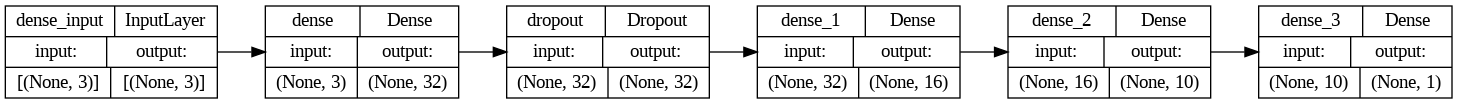

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", to_file='./kd_model.png')

In [32]:
history = model.fit(em_train, em_train_y,epochs=100,batch_size=64, validation_split = 0.3,
                         verbose=2,callbacks=[early_stopping])

Epoch 1/100
4/4 - 2s - loss: 1.0118 - tp: 34.0000 - fp: 70.0000 - tn: 83.0000 - fn: 13.0000 - accuracy: 0.5850 - precision: 0.3269 - recall: 0.7234 - auc: 0.6631 - prc: 0.3764 - val_loss: 0.9362 - val_tp: 9.0000 - val_fp: 12.0000 - val_tn: 60.0000 - val_fn: 5.0000 - val_accuracy: 0.8023 - val_precision: 0.4286 - val_recall: 0.6429 - val_auc: 0.6835 - val_prc: 0.3183 - 2s/epoch - 585ms/step
Epoch 2/100
4/4 - 0s - loss: 0.9150 - tp: 31.0000 - fp: 21.0000 - tn: 132.0000 - fn: 16.0000 - accuracy: 0.8150 - precision: 0.5962 - recall: 0.6596 - auc: 0.7724 - prc: 0.5294 - val_loss: 0.8743 - val_tp: 9.0000 - val_fp: 9.0000 - val_tn: 63.0000 - val_fn: 5.0000 - val_accuracy: 0.8372 - val_precision: 0.5000 - val_recall: 0.6429 - val_auc: 0.7649 - val_prc: 0.4704 - 128ms/epoch - 32ms/step
Epoch 3/100
4/4 - 0s - loss: 0.8620 - tp: 30.0000 - fp: 19.0000 - tn: 134.0000 - fn: 17.0000 - accuracy: 0.8200 - precision: 0.6122 - recall: 0.6383 - auc: 0.8009 - prc: 0.5323 - val_loss: 0.8267 - val_tp: 9.0000

In [33]:
en_pred = model.predict(em_test)

4/4 [==============================] - 0s 4ms/step


In [34]:
en_pred1 = [ 1 if x[0] >= 0.5 else 0 for x in en_pred]

In [35]:
print(confusion_matrix(em_test_y,en_pred1,labels=[1,0]))
print(classification_report(em_test_y,en_pred1))

[[21  7]
 [ 8 87]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        95
           1       0.72      0.75      0.74        28

    accuracy                           0.88       123
   macro avg       0.82      0.83      0.83       123
weighted avg       0.88      0.88      0.88       123



In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(em_test_y, en_pred) #곡선 그리기
score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

0.8640977443609021


In [127]:
p_list = pre_df['person_id']
em_train_id , em_test_id = train_test_split(p_list, test_size=0.3, random_state=3)

In [128]:
result = pd.DataFrame([list(em_test_id), en_pred, en_pred1])

In [129]:
result = result.T
result.columns=['ID','Proba','Pred']

In [130]:
result = pd.concat([result, em_test], axis=1)

In [131]:
y = em_test_y.reset_index()

In [132]:
result = pd.concat([result,y], axis=1)

In [43]:
result

,ID,Proba,Pred,SVM,RF,DL,index,cancer
0,638029,[0.06443691],0,0,0,0,268,0
1,714985,[0.22833098],0,1,0,0,128,0
2,197473,[0.22833098],0,1,0,0,230,0
3,321621,[0.06443691],0,0,0,0,101,0
4,1751945,[0.06443691],0,0,0,0,236,0
...,...,...,...,...,...,...,...,...
118,213450,[0.22833098],0,1,0,0,80,1
119,517322,[0.22833098],0,1,0,0,284,0
120,763742,[0.06443692],0,0,0,0,388,0
121,304185,[0.06443692],0,0,0,0,265,0


## PR-CURVE

In [ ]:
from sklearn.metrics import precision_recall_curve
# svm
precision_svm, recall_svm,_ = precision_recall_curve(y_test,svm_pred)

# random forest
precision_rf, recall_rf,_ = precision_recall_curve(y_test,rf_pred)

# dnn
precision_dnn, recall_dnn,_ = precision_recall_curve(y_test,dnn_pred)

# ensemble
precision_em, recall_em, thresholds = precision_recall_curve(em_test_y, en_pred)

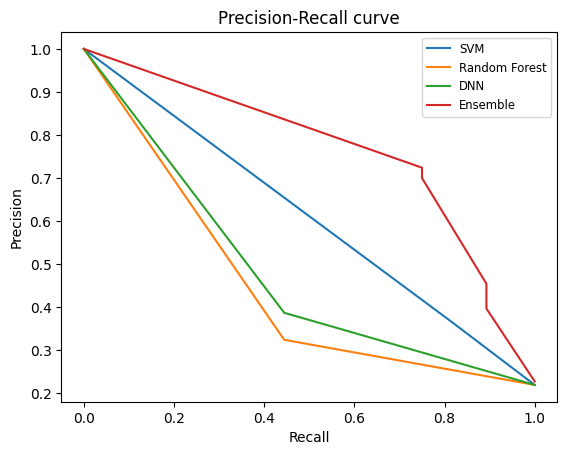

In [ ]:
plt.plot(recall_svm, precision_svm, label='SVM')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_dnn, precision_dnn, label='DNN')
plt.plot(recall_em, precision_em, label='Ensemble')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(fontsize='small')
plt.show()